# Calculating ENSO with Xarray



---

## Overview

In this notebook, we will:

1. Load SST data from the CESM2 model
2. Mask data using `.where()`
3. Compute climatologies and anomalies using `.groupby()`
4. Use `.rolling()` to compute moving average
5. Compute, normalize, and plot the Niño 3.4 Index

## Prerequisites


| Concepts | Importance | Notes |
| --- | --- | --- |
| [Introduction to Xarray](./xarray.ipynb) | Necessary | |
| [Computation and Masking](./computation-masking.ipynb) | Necessary | |



- **Time to learn**: 20 minutes

---

## Imports 


In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from pythia_datasets import DATASETS

## The Niño 3.4 Index


In this notebook, we are going to combine several topics we've covered so far to compute the [Niño 3.4 Index](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni) for the CESM2 submission for the [CMIP6 project](https://esgf-node.llnl.gov/projects/cmip6/). 

> Niño 3.4 (5N-5S, 170W-120W): The Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast. The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La Niña events are defined when the Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more.

> Nino X Index computation: (a) Compute area averaged total SST from Niño X region; (b) Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; (c) Smooth the anomalies with a 5-month running mean; (d) Normalize the smoothed values by its standard deviation over the climatological period.

![](https://www.ncdc.noaa.gov/monitoring-content/teleconnections/nino-regions.gif)

At the end of this notebook, you should be able to produce a plot that looks similar to this [Oceanic Niño Index plot](https://climatedataguide.ucar.edu/sites/default/files/styles/node_lightbox_display/public/key_figures/climate_data_set/indices_oni_2_2_lg.png?itok=61jS7Jz7):

![](https://climatedataguide.ucar.edu/sites/default/files/styles/node_lightbox_display/public/key_figures/climate_data_set/indices_oni_2_2_lg.png?itok=61jS7Jz7)

Open the SST and areacello datasets, and use Xarray's `merge` method to combine them into a single dataset:

In [2]:
filepath = DATASETS.fetch('CESM2_sst_data.nc')
data = xr.open_dataset(filepath)
filepath2 = DATASETS.fetch('CESM2_grid_variables.nc')
areacello = xr.open_dataset(filepath2).areacello

ds = xr.merge([data, areacello])
ds

/home/rf194656/anaconda3/envs/pythia-book-dev/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:    (time: 180, d2: 2, lat: 180, lon: 360)
Coordinates:
  * time       (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2) object ...
    lat_bnds   (lat, d2) float64 ...
    lon_bnds   (lon, d2) float64 ...
    tos        (time, lat, lon) float32 ...
    areacello  (lat, lon) float64 ...
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    tracking_id:            hdl:21.14100/2975ffd3-1d7b-47e3-961a-33f212ea4eb2
    variable_id:            tos
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1

Visualize the first time slice to make sure the data looks as expected:

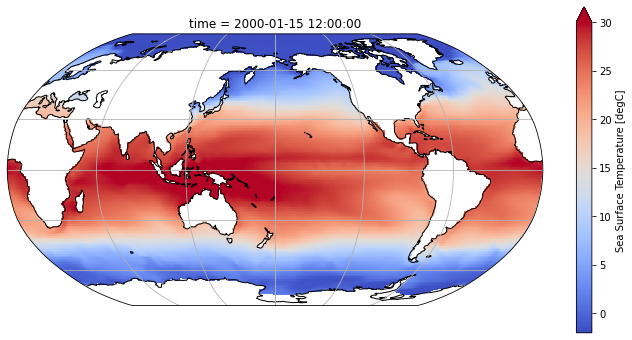

In [3]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
ds.tos.isel(time=0).plot(
    ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=30, cmap='coolwarm'
);

## Select the Niño 3.4 region 

There are a couple ways to select the Niño 3.4 region:

1. Use `sel()` or `isel()`
2. Use `where()` and select all values within the bounds of interest

In [4]:
tos_nino34 = ds.sel(lat=slice(-5, 5), lon=slice(190, 240))
tos_nino34

<xarray.Dataset>
Dimensions:    (time: 180, d2: 2, lat: 10, lon: 50)
Coordinates:
  * time       (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat        (lat) float64 -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2.5 3.5 4.5
  * lon        (lon) float64 190.5 191.5 192.5 193.5 ... 236.5 237.5 238.5 239.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2) object 2000-01-01 00:00:00 ... 2015-01-01 00:00:00
    lat_bnds   (lat, d2) float64 -5.0 -4.0 -4.0 -3.0 -3.0 ... 3.0 4.0 4.0 5.0
    lon_bnds   (lon, d2) float64 190.0 191.0 191.0 192.0 ... 239.0 239.0 240.0
    tos        (time, lat, lon) float32 ...
    areacello  (lat, lon) float64 1.233e+10 1.233e+10 ... 1.233e+10 1.233e+10
Attributes: (12/45)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    sub_experiment_id:      none
    table_id:               Omon
    tracking_id:            hdl:21.14100/2975ffd3-1d7b-47e3-961a-33f212ea4eb2
    variable_id:            tos
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1

Another option for selecting our region of interest is to use `tos_nino34 = ds.where((ds.lat<5) & (ds.lat>-5) & (ds.lon>190) & (ds.lon<240), drop=True)`.

Let's plot the selected region to make sure we are doing the right thing.

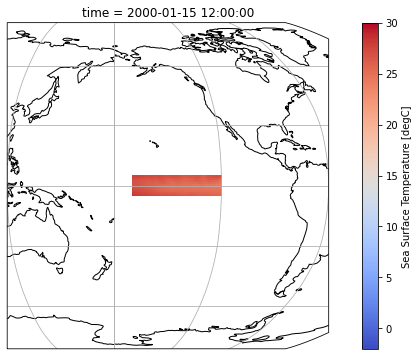

In [5]:
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
ax.gridlines()
tos_nino34.tos.isel(time=0).plot(
    ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=30, cmap='coolwarm'
)
ax.set_extent((120, 300, 10, -10))

## Compute the anomalies

We first group by month and subtract the mean SST at each point in the Niño 3.4 region. We then compute the weighted average over the region to obtain the anomalies:

In [6]:
gb = tos_nino34.tos.groupby('time.month')
tos_nino34_anom = gb - gb.mean(dim='time')
index_nino34 = tos_nino34_anom.weighted(tos_nino34.areacello).mean(dim=['lat', 'lon'])

Now, smooth the anomalies with a 5-month running mean:

In [7]:
index_nino34_rolling_mean = index_nino34.rolling(time=5, center=True).mean()

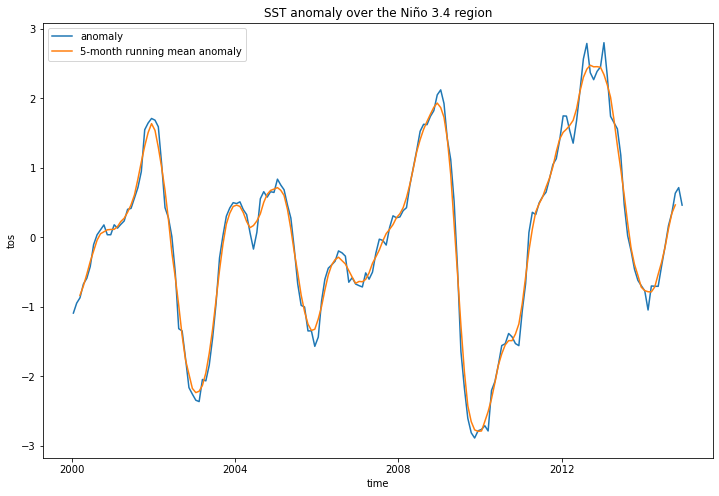

In [8]:
index_nino34.plot(size=8)
index_nino34_rolling_mean.plot()
plt.legend(['anomaly', '5-month running mean anomaly'])
plt.title('SST anomaly over the Niño 3.4 region');

We'll normalize the values by dividing the rolling mean by the standard deviation of the SST in the Niño 3.4 region:

In [9]:
std_dev = tos_nino34.tos.std()
std_dev

<xarray.DataArray 'tos' ()>
array(1.8436452, dtype=float32)

In [10]:
normalized_index_nino34_rolling_mean = index_nino34_rolling_mean / std_dev

## Visualize the computed Niño 3.4 index

We will highlight values in excess of $\pm$0.5, roughly corresponding to El Niño (warm) and La Niña (cold) events.

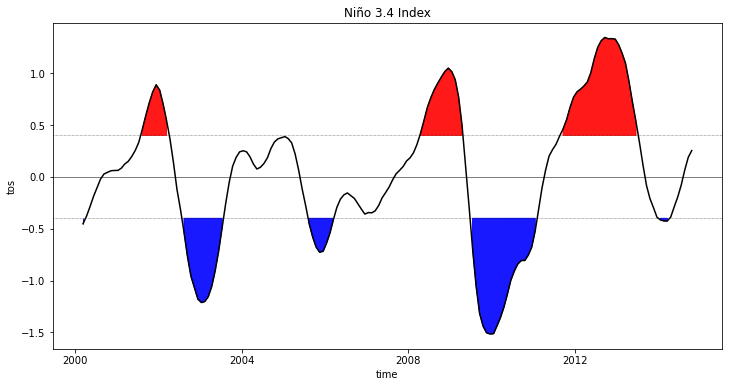

In [11]:
fig = plt.figure(figsize=(12, 6))

plt.fill_between(
    normalized_index_nino34_rolling_mean.time.data,
    normalized_index_nino34_rolling_mean.where(
        normalized_index_nino34_rolling_mean >= 0.4
    ).data,
    0.4,
    color='red',
    alpha=0.9,
)
plt.fill_between(
    normalized_index_nino34_rolling_mean.time.data,
    normalized_index_nino34_rolling_mean.where(
        normalized_index_nino34_rolling_mean <= -0.4
    ).data,
    -0.4,
    color='blue',
    alpha=0.9,
)

normalized_index_nino34_rolling_mean.plot(color='black')
plt.axhline(0, color='black', lw=0.5)
plt.axhline(0.4, color='black', linewidth=0.5, linestyle='dotted')
plt.axhline(-0.4, color='black', linewidth=0.5, linestyle='dotted')
plt.title('Niño 3.4 Index');

---

## Summary

We have applied a variety of Xarray's selection, grouping, and statistical functions to compute and visualize an important climate index. 

## Resources and References

- [Niño 3.4 index](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tnil)
- [Matplotlib's `fill_between` method](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html)
- [Matplotlib's `axhline` method](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axhline.html) (see also its analogous `axvline` method)